In [1]:
import csv
import cv2
import sys
import pickle
import random
import pandas
import numpy as np

import os
import json

import matplotlib.pyplot as plt

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from keras.regularizers import l2

from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


(8036, 7)


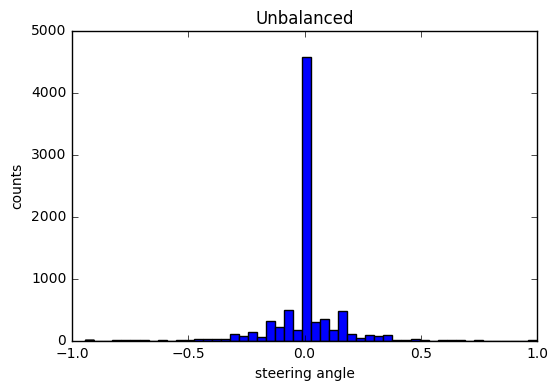

In [2]:
dir = "data"
with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
    data = pandas.read_csv(f, header=0, skipinitialspace=True).values
    print(data.shape)
plt.hist(data[:,3], bins=50)
plt.title('Unbalanced')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

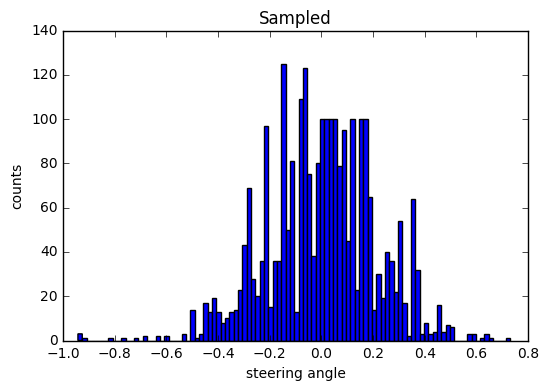

In [3]:
def sampling(data):
    st = data[:,3].astype(np.float32)
    bins, num = 100, 100
    _, b = np.histogram(st, bins)
    dist = np.digitize(st, b)
    return np.concatenate([data[dist==rng][:num] for rng in range(bins)])

sampled_data = sampling(data)
plt.hist(sampled_data[:,3], bins=100)
plt.title('Sampled')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

(7914,) (7914,)


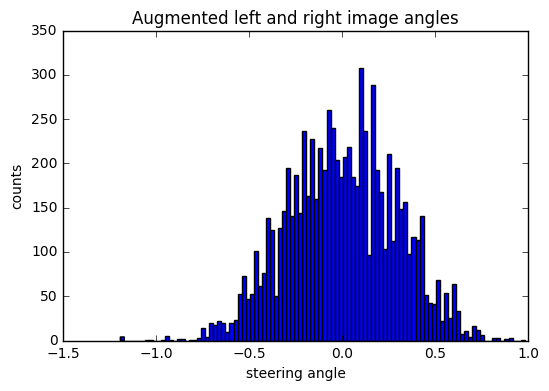

In [4]:
from sklearn.utils import shuffle

#Below code appends left and right angles. It adds angle correction of +/- 0.25 for left and right images
training_images, training_angles = [], []
center, left, right, angle, _, _, _ = np.split(sampled_data, 7, axis=1)
angle_correction = 0.25

training_images = np.append(center, left)
training_images = np.append(training_images, right)
training_angles = np.append(angle, angle + angle_correction)
training_angles = np.append(training_angles, angle - angle_correction)
print(training_images.shape, training_angles.shape)

plt.hist(training_angles, bins=100)
plt.title('Augmented left and right image angles')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

In [5]:
span = len(center)
print(training_angles[0], training_angles[span*1], training_angles[span*2])
print(training_images[0], training_images[span*1], training_images[span*2])

print("minimum",min(training_angles))
print("maximum",max(training_angles))

-0.9237437 -0.6737437 -1.1737437
IMG/center_2016_12_01_13_38_26_805.jpg IMG/left_2016_12_01_13_38_26_805.jpg IMG/right_2016_12_01_13_38_26_805.jpg
minimum -1.1926953999999999
maximum 0.9815571


In [11]:
custom_rows, custom_cols, channels = 66, 200, 3

def read_image(image):
    #image = plt.imread("data/"+image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image = cv2.resize(image, (custom_cols, custom_rows))
    image = np.reshape(image, (1, custom_rows, custom_cols, channels))

    return image

def crop_image(image):
    image = image[60:140,:,:]
    return image

def flip_image(image, angle):
    return cv2.flip(image, 1), -angle

def translate_image(img, angle):
    TRANS_X_RANGE = 100  # Number of translation pixels up to in the X direction for augmented data (-RANGE/2, RANGE/2)
    TRANS_Y_RANGE = 40  # Number of translation pixels up to in the Y direction for augmented data (-RANGE/2, RANGE/2)
    TRANS_ANGLE = .3  # Maximum angle change when translating in the X direction
    x_translation = (TRANS_X_RANGE * np.random.uniform()) - (TRANS_X_RANGE / 2)
    new_angle = angle + ((x_translation / TRANS_X_RANGE) * 2) * TRANS_ANGLE
    y_translation = (TRANS_Y_RANGE * np.random.uniform()) - (TRANS_Y_RANGE / 2)

    # Form the translation matrix
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])

    # Translate the image
    im = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
    return im, new_angle

def get_image(image, angle):
    image = plt.imread("data/"+image)
    image = crop_image(np.copy(image))
    image = read_image(image)
    return image, angle

def get_flipped_image(image, angle):
    image = plt.imread("data/"+image)
    image, angle = flip_image(np.copy(image),angle)
    image = crop_image(np.copy(image))
    image = read_image(image)
    
    return image, angle

def get_translated_image(image, angle):
    image = plt.imread("data/"+image)
    image, angle = translate_image(np.copy(image),angle)
    image = crop_image(np.copy(image))
    image = read_image(image)
    return image, angle

def get_flipped_translated_image(image, angle):
    image = plt.imread("data/"+image)
    image, angle = flip_image(np.copy(image),angle)
    #next translate
    image, angle = translate_image(image,angle)
    image = crop_image(np.copy(image))
    image = read_image(image)
    return image, angle

def my_generator(training_images, training_angles, batch_size=64):
    batch_size=32*4
    X = np.zeros((batch_size, custom_rows, custom_cols, 3))
    Y = np.zeros(batch_size)
    while True:
        training_images, training_angles = shuffle(training_images, training_angles) 
        for index, angle in enumerate(training_angles):
            #Add original image
            image, angle = get_image(training_images[index], training_angles[index])
            np.append(X,image)
            np.append(Y,angle)
            
            #Flip image
            image, angle = get_flipped_image(training_images[index], training_angles[index])
            np.append(X,image)
            np.append(Y,angle)
                
            #Translate original image
            image, angle = get_translated_image(training_images[index], training_angles[index])
            np.append(X,image)
            np.append(Y,angle)
            
            #Translate flipped image
            image, angle = get_flipped_translated_image(training_images[index], training_angles[index])
            np.append(X,image)
            np.append(Y,angle)

            if len(X)>=batch_size:
                X, Y = shuffle(X, Y)
                #print(X[0], Y[0])
                yield X, Y # (image, steering angle)
                X = np.zeros((batch_size, custom_rows, custom_cols, 3))
                Y = np.zeros(batch_size)

In [12]:
print(training_images.shape)

(7914,)


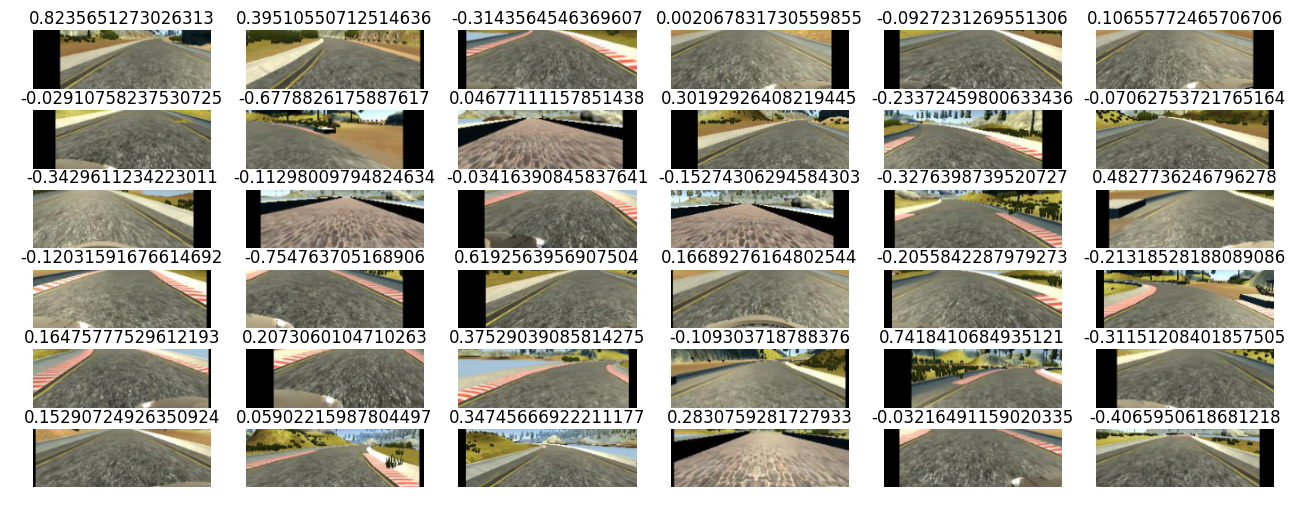

In [22]:
#Randomly print few images
plt.figure(figsize=(16,6))
for i in range(36):
    random_index = np.random.randint(0,len(training_images))
    image,angle = get_translated_image(training_images[random_index], training_angles[random_index])
    plt.subplot(6,6,i+1)
    plt.imshow(image.squeeze(), cmap="gray");
    plt.title(angle)
    plt.axis('off')
plt.show()

In [14]:
def nvidia_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=training_angles.shape))
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    #model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model

In [15]:
batch_size = 32
EPOCHS = 1
X_train, X_validation, y_train, y_validation = train_test_split(training_images, training_angles, 
                                                                test_size=0.10, random_state=0)

model = nvidia_model()

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(optimizer=adam, loss='mse')

my_generator = my_generator(X_train, y_train, batch_size)

# Model training
history = model.fit_generator(
    my_generator,
    samples_per_epoch=4*len(X_train), # of training samples
    nb_epoch=EPOCHS,
    #validation_data=(X_validation, y_validation),
    verbose=1
)

print("model training complete")

Epoch 1/1


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/site-packages/keras/engine/training.py", line 429, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-11-e99a0f4c06ab>", line 93, in my_generator
    image,angle = get_image(X[0], Y[0])
  File "<ipython-input-11-e99a0f4c06ab>", line 34, in get_image
    image = plt.imread("data/"+image)
TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')



ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

In [ ]:
#Save the model
model_json = 'model.json'
model_weights = 'model.h5'

json_string = model.to_json()
try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass

with open(model_json, 'w') as jfile:
    json.dump(json_string, jfile)
model.save(model_weights)

print("model saved")